# Customer segmentation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from cluster.cluster_functions import *
from cluster.plotting import *

from sklearn.metrics import pairwise_distances_argmin_min

%load_ext autoreload
%autoreload 2

In [2]:
invoices = pd.read_csv("data/retail/invoices_2009_2011_no_returns.csv", low_memory=False)
invoices['InvoiceDate'] = pd.to_datetime(invoices['InvoiceDate'])
invoices.dropna(inplace=True)

Segmentation is performed on customers who made three or more purchases in the first year (2009-12-1 : 2010-12-1), whilst the resulting clusters are "evaluated" on their second year purchases. Three purchases is just enough to create the aggregation features necessary to cluster on. No information regarding whether a customer's purchase is a repeat purchase (or is their very first purchase) is avaiable.  

In [3]:
cohort_customer_ids = invoices[invoices.InvoiceDate<'2010-12-1'].CustomerID.unique()
cohort_invoices = invoices[invoices.CustomerID.isin(cohort_customer_ids)]

<br>
<br>

# Cluster on RFM features

**KMeans**

In [4]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_total_first_year_revenue(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])
features.head()

,CustomerID,MeanPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,frequency,recency,T,monetary_value,T_Minus_Recency,TotalFirstYearRevenue,log(1+TotalFirstYearRevenue),SecondYearRLV
0,12346.0,84.680000,81.501128,27.05,142.31,169.36,2,1.0,118.0,273.0,142.310,155.0,169.36,5.137914,77183.60
1,12349.0,1110.570000,59.467680,1068.52,1152.62,2221.14,2,1.0,182.0,215.0,1152.620,30.0,2221.14,7.706226,1457.55
2,12352.0,171.900000,39.810112,143.75,200.05,343.80,2,1.0,17.0,18.0,200.050,64.0,343.80,5.842965,1385.74
3,12356.0,1042.083333,840.956062,349.85,1977.96,3126.25,3,2.0,44.0,50.0,1163.905,33.0,3126.25,8.047909,2487.43
4,12358.0,839.670000,581.088065,268.10,1429.83,2519.01,3,2.0,356.0,357.0,544.590,1.0,2519.01,7.832018,928.06


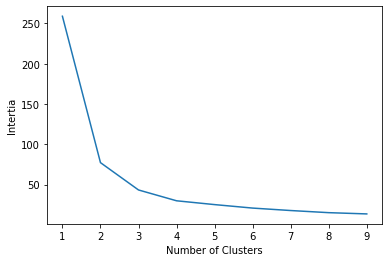

In [5]:
cluster_feats = [
    'recency',
    'frequency',
    'monetary_value'   
]

cluster_elbow_method(features, cluster_feats, scaler='mm')

Inertia for 4 clusters: 29.965882314695747
Cluster labels - 0 = Low value customer, 4 = High value customer
Silhouette Coefficient: 0.5023364240277475
Median 2nd year RLV: [(0, 282.0, 2), (1, 397.0, 2), (2, 716.0, 2), (3, 1736.0, 2)]
Differences: [115.26, 318.56, 1020.44]
Value Counts:
0    584
1    672
2    735
3    756
Name: Cluster, dtype: int64
Explained variance ratio: [0.93689441 0.03653677]
Total explained variance: 0.9734311837519661


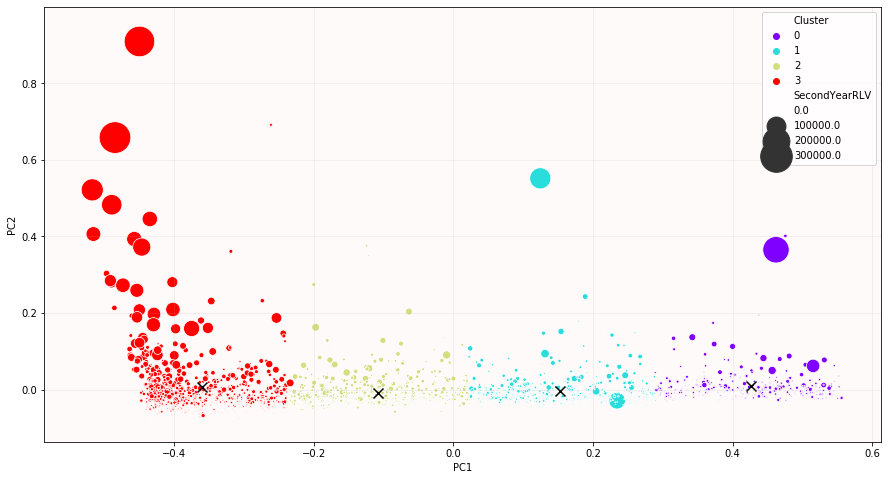

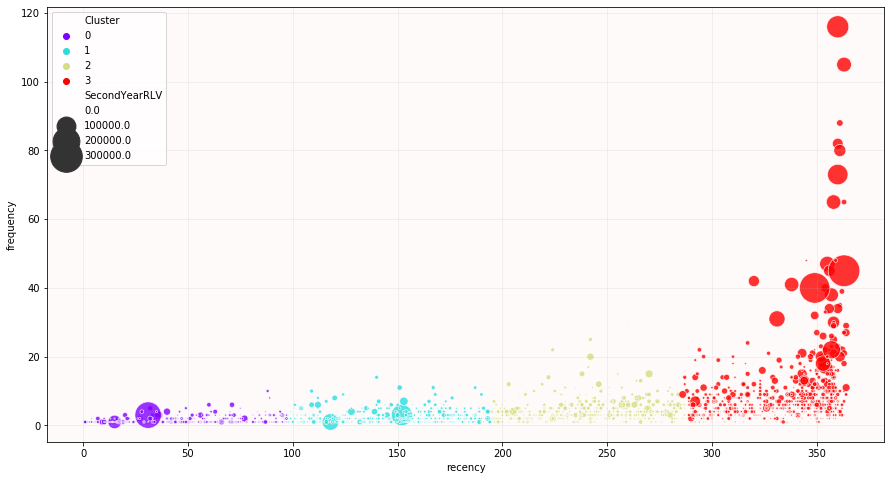

In [6]:
num_clusters = 4
features, scaler, cluster_centers  = perform_km_clustering(features, cluster_feats, num_clusters, scaler='mm')
features, sorted_cluster_centers = reorder_clusters(features, cluster_centers, num_clusters)
evaluate_clusters(features, num_clusters, cluster_feats, scaler)
pca = cluster_pca_plot(features, cluster_feats, scaler, sorted_cluster_centers)
# tsne = cluster_tsne_plot(features, cluster_feats, scaler, perplexity=40)
cluster_rf_plot(features)

<br>
<br>

**GMM**

In [7]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_total_first_year_revenue(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])
features.head()

,CustomerID,MeanPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,frequency,recency,T,monetary_value,T_Minus_Recency,TotalFirstYearRevenue,log(1+TotalFirstYearRevenue),SecondYearRLV
0,12346.0,84.680000,81.501128,27.05,142.31,169.36,2,1.0,118.0,273.0,142.310,155.0,169.36,5.137914,77183.60
1,12349.0,1110.570000,59.467680,1068.52,1152.62,2221.14,2,1.0,182.0,215.0,1152.620,30.0,2221.14,7.706226,1457.55
2,12352.0,171.900000,39.810112,143.75,200.05,343.80,2,1.0,17.0,18.0,200.050,64.0,343.80,5.842965,1385.74
3,12356.0,1042.083333,840.956062,349.85,1977.96,3126.25,3,2.0,44.0,50.0,1163.905,33.0,3126.25,8.047909,2487.43
4,12358.0,839.670000,581.088065,268.10,1429.83,2519.01,3,2.0,356.0,357.0,544.590,1.0,2519.01,7.832018,928.06


Cluster labels - 0 = Low value customer, 4 = High value customer
Silhouette Coefficient: 0.02810406231858296
Median 2nd year RLV: [(0, 199.0, 2), (1, 461.0, 2), (2, 2066.0, 2), (3, 6315.0, 2)]
Differences: [261.74, 1605.34, 4248.63]
Value Counts:
0    825
1    931
2    840
3    151
Name: Cluster, dtype: int64
Explained variance ratio: [0.93689441 0.03653677]
Total explained variance: 0.9734311837519665


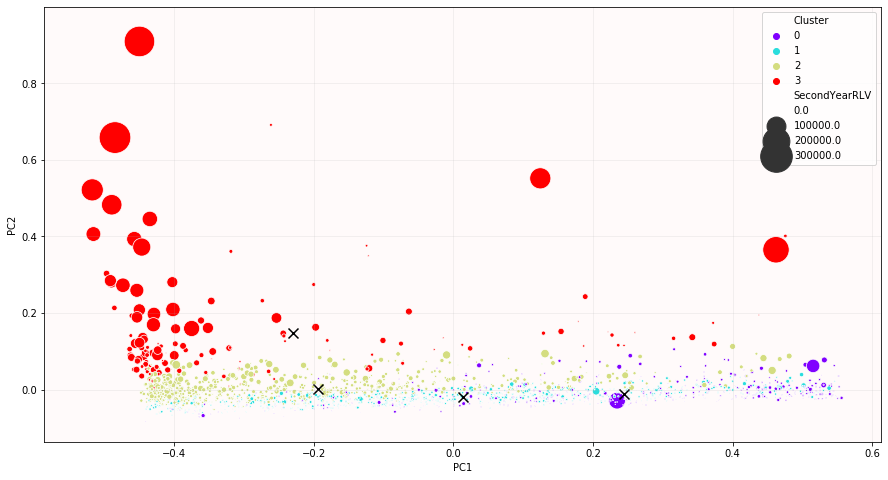

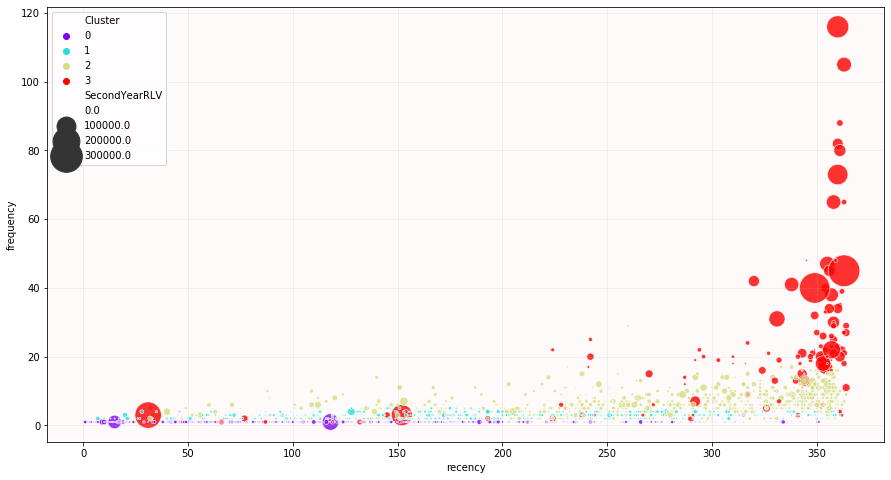

In [8]:
num_clusters = 4
features, scaler, cluster_centers  = perform_gmm_clustering(features, cluster_feats, num_clusters, scaler='mm')
features, sorted_cluster_centers = reorder_clusters(features, cluster_centers, num_clusters)
evaluate_clusters(features, num_clusters, cluster_feats, scaler)
pca = cluster_pca_plot(features, cluster_feats, scaler, sorted_cluster_centers)
# tsne = cluster_tsne_plot(features, cluster_feats, scaler, perplexity=40)
cluster_rf_plot(features)

<br>
<br>

# Cluster on monetary aggregation features

**KMeans**

In [9]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_total_first_year_revenue(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])

feats_to_transform = [
    'MeanPurchaseValue', 
    'StDevPurchaseValue',
    'MinPurchaseValue', 
    'MaxPurchaseValue', 
    'SumPurchaseValue', 
]
features, transformed_feat_names = transform_features(features, feats_to_transform, transform="log")

features.head()

,CustomerID,log(1+MeanPurchaseValue),log(1+StDevPurchaseValue),log(1+MinPurchaseValue),log(1+MaxPurchaseValue),log(1+SumPurchaseValue),SizePurchaseValue,frequency,recency,T,monetary_value,T_Minus_Recency,TotalFirstYearRevenue,log(1+TotalFirstYearRevenue),SecondYearRLV
0,12346.0,4.450619,4.412812,3.333989,4.965010,5.137914,2,1.0,118.0,273.0,142.310,155.0,169.36,5.137914,77183.60
1,12349.0,7.013529,4.102109,6.974965,7.050660,7.706226,2,1.0,182.0,215.0,1152.620,30.0,2221.14,7.706226,1457.55
2,12352.0,5.152713,3.708930,4.975008,5.303554,5.842965,2,1.0,17.0,18.0,200.050,64.0,343.80,5.842965,1385.74
3,12356.0,6.949936,6.735728,5.860359,7.590327,8.047909,3,2.0,44.0,50.0,1163.905,33.0,3126.25,8.047909,2487.43
4,12358.0,6.734199,6.366622,5.595083,7.266010,7.832018,3,2.0,356.0,357.0,544.590,1.0,2519.01,7.832018,928.06


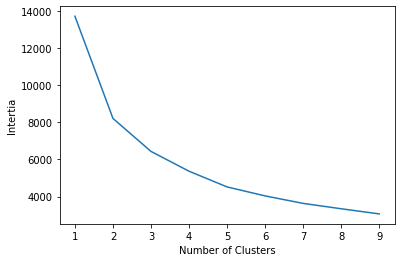

In [10]:
cluster_feats = transformed_feat_names

cluster_elbow_method(features, cluster_feats, scaler='normal')

Inertia for 4 clusters: 5366.066116102085
Cluster labels - 0 = Low value customer, 4 = High value customer
Silhouette Coefficient: 0.31871843473698724
Median 2nd year RLV: [(0, 179.0, 2), (1, 700.0, 2), (2, 1098.0, 2), (3, 3024.0, 2)]
Differences: [520.9, 398.3, 1925.44]
Value Counts:
0     705
1    1332
2     242
3     468
Name: Cluster, dtype: int64
Explained variance ratio: [0.70105714 0.20946052]
Total explained variance: 0.9105176604972636


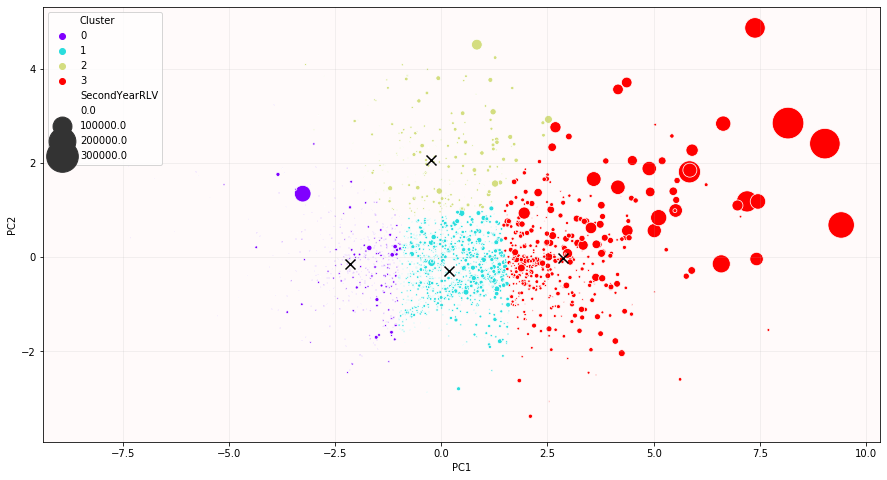

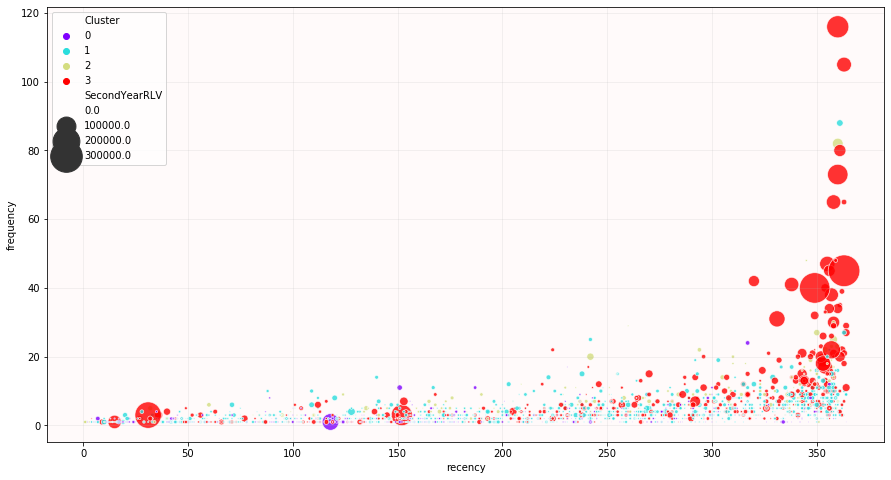

In [11]:
num_clusters = 4
features, scaler, cluster_centers  = perform_km_clustering(features, cluster_feats, num_clusters, scaler='normal')
features, sorted_cluster_centers = reorder_clusters(features, cluster_centers, num_clusters)
evaluate_clusters(features, num_clusters, cluster_feats, scaler)
pca = cluster_pca_plot(features, cluster_feats, scaler, sorted_cluster_centers)
# tsne = cluster_tsne_plot(features, cluster_feats, scaler, perplexity=40, n_iter=2000)
cluster_rf_plot(features)

<br>
<br>

**GMM**

In [12]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_total_first_year_revenue(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])

feats_to_transform = [
    'MeanPurchaseValue', 
    'StDevPurchaseValue',
    'MinPurchaseValue', 
    'MaxPurchaseValue', 
    'SumPurchaseValue',
    'SizePurchaseValue'
]

features, transformed_feat_names = transform_features(features, feats_to_transform, transform="log")

features.head()

,CustomerID,log(1+MeanPurchaseValue),log(1+StDevPurchaseValue),log(1+MinPurchaseValue),log(1+MaxPurchaseValue),log(1+SumPurchaseValue),log(1+SizePurchaseValue),frequency,recency,T,monetary_value,T_Minus_Recency,TotalFirstYearRevenue,log(1+TotalFirstYearRevenue),SecondYearRLV
0,12346.0,4.450619,4.412812,3.333989,4.965010,5.137914,1.098612,1.0,118.0,273.0,142.310,155.0,169.36,5.137914,77183.60
1,12349.0,7.013529,4.102109,6.974965,7.050660,7.706226,1.098612,1.0,182.0,215.0,1152.620,30.0,2221.14,7.706226,1457.55
2,12352.0,5.152713,3.708930,4.975008,5.303554,5.842965,1.098612,1.0,17.0,18.0,200.050,64.0,343.80,5.842965,1385.74
3,12356.0,6.949936,6.735728,5.860359,7.590327,8.047909,1.386294,2.0,44.0,50.0,1163.905,33.0,3126.25,8.047909,2487.43
4,12358.0,6.734199,6.366622,5.595083,7.266010,7.832018,1.386294,2.0,356.0,357.0,544.590,1.0,2519.01,7.832018,928.06


Cluster labels - 0 = Low value customer, 4 = High value customer
Silhouette Coefficient: 0.056634100674289416
Median 2nd year RLV: [(0, 214.0, 2), (1, 495.0, 2), (2, 1612.0, 2), (3, 1800.0, 2)]
Differences: [281.12, 1116.95, 187.98]
Value Counts:
0    768
1    810
2    703
3    466
Name: Cluster, dtype: int64
Explained variance ratio: [0.62117211 0.23783554]
Total explained variance: 0.859007649831134


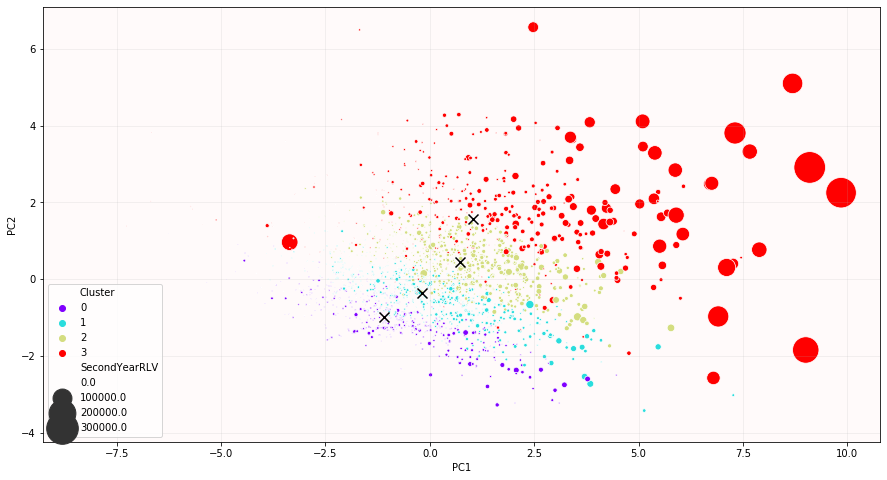

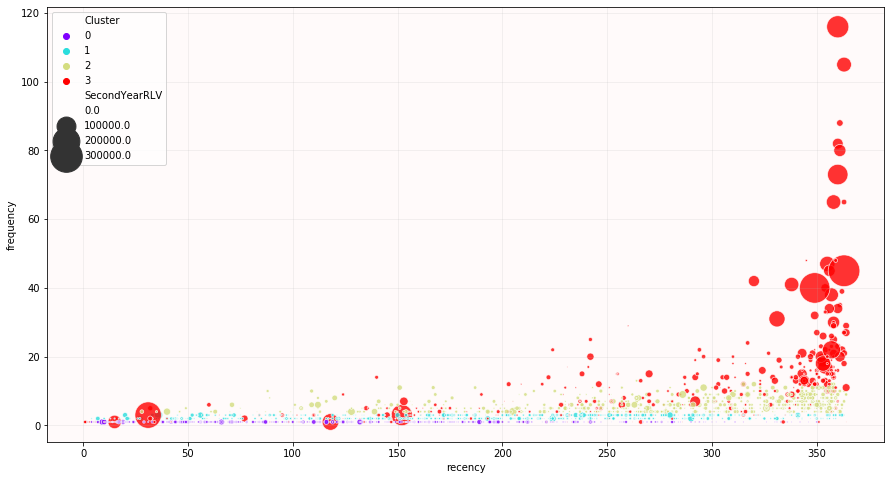

In [13]:
cluster_feats = transformed_feat_names

num_clusters = 4
features, scaler, cluster_centers  = perform_gmm_clustering(features, cluster_feats, num_clusters, scaler='normal')
features, sorted_cluster_centers = reorder_clusters(features, cluster_centers, num_clusters)
evaluate_clusters(features, num_clusters, cluster_feats, scaler)
pca = cluster_pca_plot(features, cluster_feats, scaler, sorted_cluster_centers)
# tsne = cluster_tsne_plot(features, cluster_feats, scaler, perplexity=40, n_iter=2000)
cluster_rf_plot(features)

<br>
<br>

# Pareto

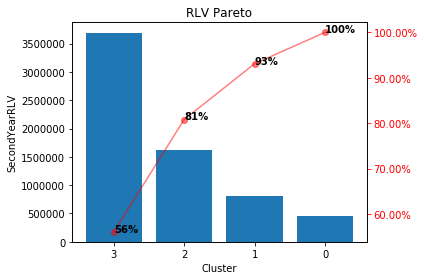

In [14]:
df = features.groupby('Cluster')['SecondYearRLV'].sum().reset_index()
df['Cluster'] = df['Cluster'].astype(str)
pareto_plot(df, x='Cluster', y='SecondYearRLV', show_pct_y=True, title='RLV Pareto')

<br>
<br>

# Cluster statistics and distributions

**Mean Cluster Features**

In [15]:
for cluster in range(num_clusters):
    print(f"Cluster: {cluster}")
    features_copy = features[features.Cluster==cluster].copy()
    for idx, col in enumerate(cluster_feats):
        features_copy[col] = np.exp(features_copy[col]) - 1  # Reverse log transform
        features_copy.rename(columns={col:feats_to_transform[idx]}, inplace=True)
    print(features_copy.mean())
    print()
del features_copy

Cluster: 0
CustomerID                      15279.216146
MeanPurchaseValue                 375.861556
StDevPurchaseValue                110.553282
MinPurchaseValue                  297.688581
MaxPurchaseValue                  454.034531
SumPurchaseValue                  751.723112
SizePurchaseValue                   2.000000
frequency                           1.000000
recency                           118.455729
T                                 201.631510
monetary_value                    376.226615
T_Minus_Recency                    85.759115
TotalFirstYearRevenue             751.723112
log(1+TotalFirstYearRevenue)        6.377116
SecondYearRLV                     591.313451
Cluster                             0.000000
dtype: float64

Cluster: 1
CustomerID                      15288.703704
MeanPurchaseValue                 405.754906
StDevPurchaseValue                166.389963
MinPurchaseValue                  254.559790
MaxPurchaseValue                  592.276222
SumPurchaseValue 

**Why log transform?**

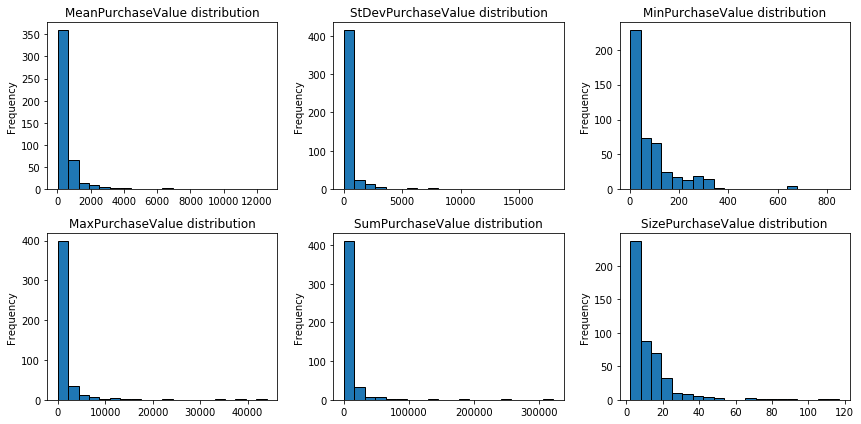

In [16]:
cluster = 3
fig = plt.figure(figsize=(12,6))
for idx, feat in enumerate(cluster_feats):
    ax = fig.add_subplot(2,3,idx+1)
    (np.exp(features[features.Cluster==cluster][feat])-1).plot.hist(bins=20, ax=ax, edgecolor='k')
    ax.set_title(f"{feat[6:-1]} distribution")
plt.tight_layout()

Before log transformations all of the monetary aggregation features are right skewed. This exaggerates the difference between the highest spending customers and those who are also relatively high spenders but don't spend as much which is undesirable. The clustering algorithms won't group these customers together unless the right side of the axis is "squashed" together which the log(1+X) transform achieves.  

<br>
<br>

**Typical Customer**

In [17]:
closest, _ = pairwise_distances_argmin_min(sorted_cluster_centers, scaler.transform(features[cluster_feats]))
closest

array([1210, 1002, 1775, 2414], dtype=int64)

In [21]:
typical_customers = []
for i, idx in enumerate(closest):
    typical_customers.append(features.iloc[idx].CustomerID)
    features_copy = features.copy()
    for j, col in enumerate(cluster_feats):
        features_copy[col] = np.exp(features_copy[col]) - 1  # Reverse log transform
        features_copy.rename(columns={col:feats_to_transform[j]}, inplace=True)
    print(f"Cluster: {i}")
    print(features_copy.iloc[idx])
    print()
del features_copy

Cluster: 0
CustomerID                      14986.000000
MeanPurchaseValue                 283.450000
StDevPurchaseValue                 56.469548
MinPurchaseValue                  243.520000
MaxPurchaseValue                  323.380000
SumPurchaseValue                  566.900000
SizePurchaseValue                   2.000000
frequency                           1.000000
recency                           308.000000
T                                 310.000000
monetary_value                    243.520000
T_Minus_Recency                    74.000000
TotalFirstYearRevenue             566.900000
log(1+TotalFirstYearRevenue)        6.341945
SecondYearRLV                       0.000000
Cluster                             0.000000
Name: 1210, dtype: float64

Cluster: 1
CustomerID                      14538.000000
MeanPurchaseValue                 327.530000
StDevPurchaseValue                122.957459
MinPurchaseValue                  206.800000
MaxPurchaseValue                  452.600000
SumPu

In [20]:
daily_customer_revenues = cohort_invoices.groupby(["CustomerID", pd.Grouper(key='InvoiceDate', freq='D')])['Revenue'].sum().reset_index()
for customer in typical_customers:
    print(daily_customer_revenues[daily_customer_revenues.CustomerID==customer].to_string(index=False))
    print()

 CustomerID InvoiceDate  Revenue
    14986.0  2010-01-24   323.38
    14986.0  2010-11-28   243.52

 CustomerID InvoiceDate  Revenue
    14538.0  2010-01-25   452.60
    14538.0  2010-06-13   206.80
    14538.0  2010-06-27   323.19
    14538.0  2011-03-28   106.50
    14538.0  2011-10-06   281.75

 CustomerID InvoiceDate  Revenue
    16190.0  2009-12-14   196.92
    16190.0  2010-04-19   411.44
    16190.0  2010-05-28   378.61
    16190.0  2010-07-01   324.74
    16190.0  2010-08-13   280.13
    16190.0  2010-10-13   608.13
    16190.0  2010-11-10   308.50
    16190.0  2011-10-30   215.08

 CustomerID InvoiceDate  Revenue
    17526.0  2009-12-17   729.12
    17526.0  2010-01-21    54.95
    17526.0  2010-03-21   346.38
    17526.0  2010-06-09   543.80
    17526.0  2010-08-20   235.95
    17526.0  2010-10-12   327.30
    17526.0  2010-11-29   505.84
    17526.0  2010-12-09   226.80
    17526.0  2010-12-14    11.80
    17526.0  2011-02-22   634.20
    17526.0  2011-12-05   323.10



<br>
<br>